This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multiclass classifier to predict the tag for a programming question on Stack Overflow.


In [91]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import random
import shutil
import string
import tensorflow as tf

from collections import Counter
from sklearn.feature_extraction import text
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# restrict the memory of GPU to 1GB
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]
)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.





### Gather Data

Let's download and extract IMDB dataset, then explore the directory structure.

In [6]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True)
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

print(dataset)

84131840/84125825 [==============================] - 12s 0us/step
/root/.keras/datasets/aclImdb_v1.tar.gz


In [6]:
print(dataset_dir)
os.listdir(dataset_dir)

/root/.keras/datasets/aclImdb


['test', 'train', 'imdbEr.txt', 'imdb.vocab', 'README']

In [146]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'labeledBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [17]:
def get_files(base_dir):
    pos_dir = os.path.join(base_dir, 'pos')
    pos_files = os.listdir(pos_dir)
    pos_files = [os.path.join(pos_dir, file_name) for file_name in pos_files]
    
    neg_dir = os.path.join(base_dir, 'neg')
    neg_files = os.listdir(neg_dir)
    neg_files = [os.path.join(neg_dir, file_name) for file_name in neg_files]    

    return pos_files, neg_files

train_pos_files, train_neg_files = get_files(os.path.join(dataset_dir, 'train'))
test_pos_files, test_files = get_files(os.path.join(dataset_dir, 'test'))
    
print('train dataset: {} positive reviews, {} negative reviews'.format(len(train_pos_files), len(train_neg_files)))
print('test dataset: {} positive reviews, {} negative reviews'.format(len(test_pos_files), len(test_files)))

train dataset: 12500 positive reviews, 12500 negative reviews
test dataset: 12500 positive reviews, 12500 negative reviews


In [20]:
for file_path in train_pos_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...')  

------------------------------/root/.keras/datasets/aclImdb/train/pos/127_7.txt------------------------------
Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.
------------------------------/root/.keras/datasets/aclImdb/train/pos/126_10.txt------------------------------
Zentropa is the most original movie I've seen in y

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [22]:
for file_path in train_neg_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...') 

------------------------------/root/.keras/datasets/aclImdb/train/neg/127_4.txt------------------------------
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher ...
------------------------------/root/.keras/datasets/aclImdb/train/neg/126_1.txt------

In [31]:
def load_imdb_sentiment_analysis_dataset(imdb_data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

(train_texts, train_labels), (test_texts, test_labels) = load_imdb_sentiment_analysis_dataset(dataset_dir)
print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=25000, train_labels.shape=(25000,)
test_texts.length=25000, test_labels.shape=(25000,)


In [38]:

np.bincount(np.array([3, 3, 5, 1, 1, 1, 4, 4, 4, 4]))

array([0, 3, 0, 2, 4, 1])

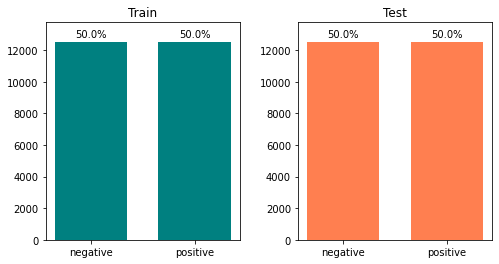

In [46]:
def plot_distribution(train_labels, test_labels, classes):
    '''class distribution'''
    def plot_dist(labels, title, color='blue', width = 0.7):        
        bin_count = np.bincount(labels)       
        bin_percentage = bin_count/len(labels)
        rects = plt.bar(classes, bin_count, width, color=color)
        plt.title(title)
        plt.ylim(0,max(bin_count)*1.1) 
        
        for i, r in enumerate(rects):
            plt.annotate('{:0.1f}%'.format(int(bin_percentage[i]*100)),
                        xy=(r.get_x() + r.get_width() / 2, r.get_height()),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')        

    classes_count = len(classes)            
    height = min(16, classes_count*4)
    plt.figure(figsize=(height, 4))
    plt.subplot(121)
    plot_dist(train_labels, 'Train', color='teal')
    plt.subplot(122)
    plot_dist(test_labels, 'Test', color='coral')
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3) 
    plt.show()    

classes=['negative', 'positive']    
plot_distribution(train_labels, test_labels, classes)

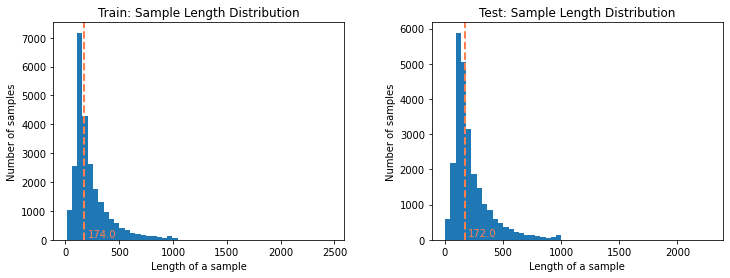

In [79]:
def plot_length_distribution(train_text_lengths, test_text_lengths):
    
    def plot_length_dist(lengths, title):
        median = np.median(lengths)
        plt.hist(lengths, 50)
        plt.axvline(x=median, color='coral', linestyle='dashed', linewidth=2)
        plt.text(median+30, 100, median, color='coral')
        plt.xlabel('Length of a sample')
        plt.ylabel('Number of samples')
        plt.title('{}: Sample Length Distribution'.format(title))          


    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plot_length_dist(train_text_lengths, 'Train')
    plt.subplot(122)
    plot_length_dist(test_text_lengths, 'Test')
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3) 
    plt.show()    

    
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
plot_length_distribution(train_text_lengths, test_text_lengths)

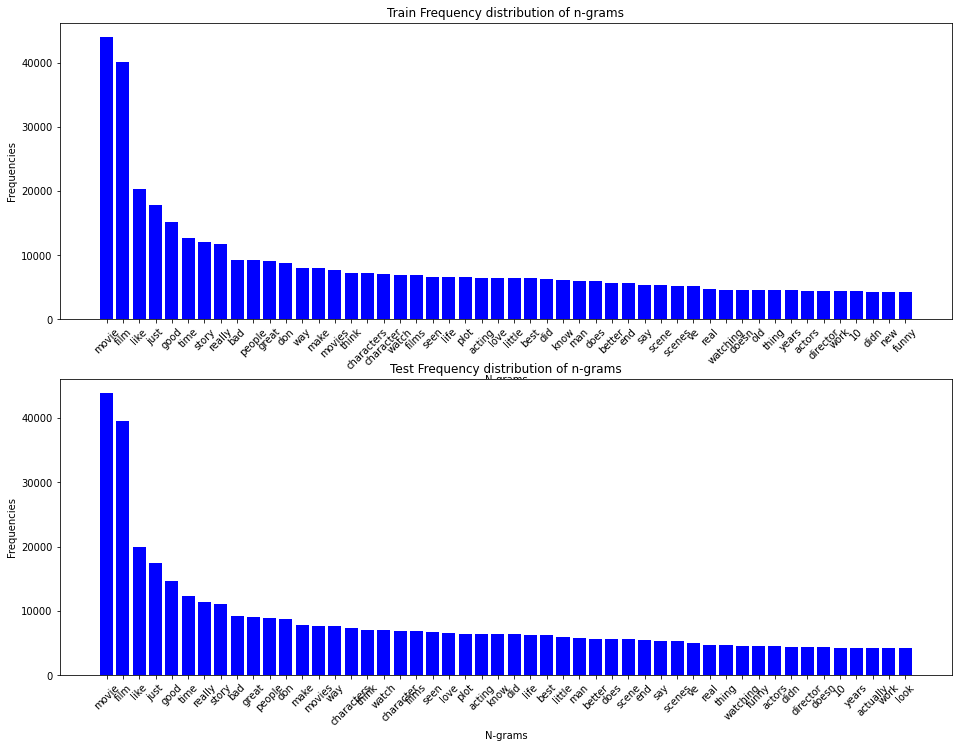

In [103]:
def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50,
                                          stop_words=None,
                                          title=''
                                         ):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
            'stop_words': stop_words
    }
    vectorizer = text.CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('{} Frequency distribution of n-grams'.format(title))
    plt.xticks(idx, ngrams, rotation=45)


def plot_frequency_distribution(train_texts, test_texts, stop_words=None) :  
    plt.figure(figsize=(16, 12))
    plt.subplot(211)
    plot_frequency_distribution_of_ngrams(train_texts, title='Train', stop_words=stop_words)  
    plt.subplot(212)
    plot_frequency_distribution_of_ngrams(test_texts, title='Test', stop_words=stop_words)   
    plt.show()
    
stop_words = text.ENGLISH_STOP_WORDS.union(["br"])    
plot_frequency_distribution(train_texts, test_texts, stop_words=stop_words)

In [129]:
cnt = Counter()
for word in ['red', 'blue', 'red', 'green', 'blue', 'blue']:
    cnt[word] += 1

print(cnt)
print(len(cnt))
print(cnt.keys())
print(cnt.values())
list(cnt)
for word in list(cnt):
 
    if cnt[word]<2: cnt.pop(word)
print(cnt)

Counter({'blue': 3, 'red': 2, 'green': 1})
3
dict_keys(['red', 'blue', 'green'])
dict_values([2, 3, 1])
Counter({'blue': 3, 'red': 2})


In [136]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<100: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 438729
Number of Vocabulary: 7706


In [139]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 143.7


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

In [143]:
train_dir


'/root/.keras/datasets/aclImdb/train/pos'

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [149]:
train_dir = os.path.join(dataset_dir, 'train')
print(os.listdir(train_dir))
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
print(os.listdir(train_dir))

['neg', 'pos', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt', 'unsup']
['neg', 'pos', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [150]:
batch_size = 32
seed = 42


raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'train'), 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [159]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'train'), 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

print('-'*100)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'train'), 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

print('-'*100)
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'test'), 
    batch_size=batch_size)

for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print('-'*50, label_batch.numpy()[i], '-'*50)
        print(text_batch.numpy()[i])
        
print('-'*100)
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])       

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
----------------------------------------------------------------------------------------------------
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
----------------------------------------------------------------------------------------------------
Found 25000 files belonging to 2 classes.
-------------------------------------------------- 0 --------------------------------------------------
b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, b

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [156]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [28]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'train'), 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [29]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'test'), 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Note: The Preprocessing APIs used in the following section are experimental in TensorFlow 2.3 and subject to change.

### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `preprocessing.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowecase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: to prevent [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also know as train/serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [140]:
'[%s]' % re.escape(string.punctuation)

'[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'

In [141]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. you will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [160]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: it's important to only use your training data when calling adapt (using the test set would leak information).

In [161]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [163]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [166]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print(label_batch)
print('-'*50, 'Review', '-'*50)
print(first_review)
print('-'*50, 'Label', '-'*50)
print("Label", raw_train_ds.class_names[first_label])
print('-'*50, 'Vectorized review', '-'*50)
print("Vectorized review", vectorize_text(first_review, first_label))

tf.Tensor([0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 0 0], shape=(32,), dtype=int32)
-------------------------------------------------- Review --------------------------------------------------
tf.Tensor(b'Recipe for one of the worst movies of all time: a she-male villain who looks like it escaped from the WWF, has terrible aim with a gun that has inconsistent effects (the first guy she shoots catches on fire but when she shoots anyone else they just disappear) and takes time out to pet a deer. Then you got the unlikable characters, 30 year old college students, a lame attempt at a surprise ending and lots, lots more. Avoid at all costs.', shape=(), dtype=string)
-------------------------------------------------- Label --------------------------------------------------
Label neg
-------------------------------------------------- Vectorized review --------------------------------------------------
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [52]:
print("7 ---> ",vectorize_layer.get_vocabulary()[7])
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

7 --->  is
1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [171]:
max_features = 10000
sequence_length = 250

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

print("7 ---> ",vectorize_layer.get_vocabulary()[7])
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

7 --->  is
1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [170]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [178]:
vector_batch, label_batch = next(iter(train_ds))
first_vector, first_label = vector_batch[0], label_batch[0]

print('Label：{}'.format(raw_train_ds.class_names[first_label]))
print('-'*50, 'Vector', '-'*50)
print(first_vector.numpy())
print('-'*50, 'orginal review', '-'*50)
print(' '.join([vectorize_layer.get_vocabulary()[v] for v in first_vector]))

Label：pos
-------------------------------------------------- Vector --------------------------------------------------
[  48    4 1285  526 5786  708   17    2   63  673    5    4  112  713
  336  161  247   36   43  407   39 4347    3  631    9 1168    6 5339
   39  444    7   77   52    1   61    4 4494   68    1   64    1   30
  710  422   76    1 6591    1    7  506   14    2  112  478 6283   14
   55   13   14    2    1    8  704    3    1  146   45   22   38  192
 6591    1    3  654  336 4403    1   91 4341    1    7   14  204    4
 1784 3640    8   11 4066    3    1 1028   17    1    1    2  112  713
  336  161    7 1192    3    4   88 1088  181  516    2   19    7  443
   20    4  274   63   60  158    9   37    1    7    4 3159    6    2
 4982    5  390    1   60    7  688 8655    3  688    7  125   30  183
  167    8   11  875  182   71  419    8 6287  392  167   30  422   32
    1   12   47    4  171    5 1285   79    8    2  182   16  741    5
  115    6  193  571    1    

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [42]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create our neural network:

In [187]:
embedding_dim = 16

In [204]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [214]:
def get_rnn(embedding_dim, dropput=0):
    model = tf.keras.Sequential([
        layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True),
        layers.GRU(units=32),
        layers.Dense(units=1)])
    model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=tf.metrics.BinaryAccuracy(threshold=0.0))    
    return model 

model = get_rnn(embedding_dim=32)
model.summary()  

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 32)          320032    
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 326,401
Trainable params: 326,401
Non-trainable params: 0
_________________________________________________________________


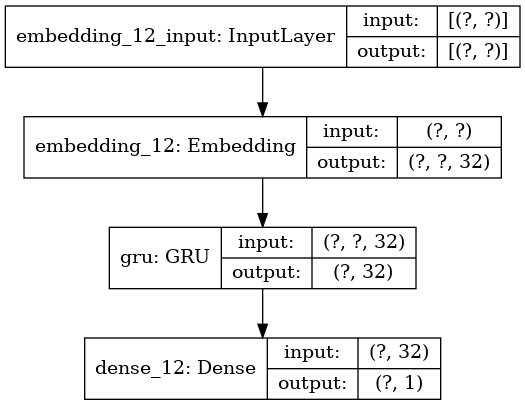

In [215]:
 tf.keras.utils.plot_model(model, '{}.png'.format(model.name), show_shapes=True) 

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, see the [word embedding tutorial](../text/word_embeddings.ipynb).
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. 
4. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [209]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [216]:
epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
625/625 [==============================] - 11s 18ms/step - loss: 0.5047 - binary_accuracy: 0.7358 - val_loss: 0.3499 - val_binary_accuracy: 0.8584
Epoch 2/5
625/625 [==============================] - 10s 16ms/step - loss: 0.2789 - binary_accuracy: 0.8914 - val_loss: 0.3470 - val_binary_accuracy: 0.8556
Epoch 3/5
625/625 [==============================] - 10s 16ms/step - loss: 0.2106 - binary_accuracy: 0.9236 - val_loss: 0.3770 - val_binary_accuracy: 0.8484
Epoch 4/5
625/625 [==============================] - 10s 16ms/step - loss: 0.1713 - binary_accuracy: 0.9410 - val_loss: 0.3468 - val_binary_accuracy: 0.8638
Epoch 5/5
625/625 [==============================] - 10s 16ms/step - loss: 0.1382 - binary_accuracy: 0.9545 - val_loss: 0.3930 - val_binary_accuracy: 0.8690


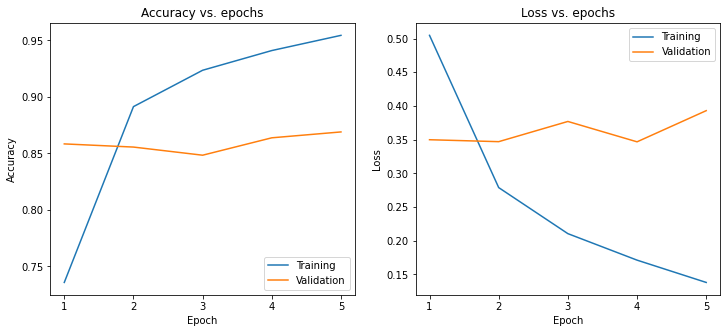

Loss: 0.45158, Accuracy: 85.1%


In [225]:
def plot_history(history):
    '''显示训练的loss和accuracy的走势图'''
    plt.figure(figsize=(12, 5))
    epochs = range(1, len(history.history['binary_accuracy'])+1)
    plt.subplot(121)
    plt.plot(epochs, history.history['binary_accuracy'])
    plt.plot(epochs, history.history['val_binary_accuracy'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend(['Training', 'Validation'], loc='lower right')

    plt.subplot(122)
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show() 
    
def evaluate(test_ds):
    loss, accuracy = model.evaluate(test_ds, verbose=False)
    print("Loss: {:0.5f}, Accuracy: {:0.1f}%".format(loss, accuracy*100))

plot_history(history)    
evaluate(test_ds)    

In [223]:
def evaluate(test_ds):
    loss, accuracy = model.evaluate(test_ds, verbose=False)
    print("Loss: {:0.5f}, Accuracy: {:0.1f}%".format(loss, accuracy*100))

evaluate(test_ds)

Loss: 0.45158, Accuracy: 85.1%


In [207]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.6655 - binary_accuracy: 0.6872 - val_loss: 0.6168 - val_binary_accuracy: 0.7718
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.5502 - binary_accuracy: 0.7984 - val_loss: 0.4991 - val_binary_accuracy: 0.8214
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.4448 - binary_accuracy: 0.8435 - val_loss: 0.4204 - val_binary_accuracy: 0.8462
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3790 - binary_accuracy: 0.8660 - val_loss: 0.3740 - val_binary_accuracy: 0.8610
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3365 - binary_accuracy: 0.8788 - val_loss: 0.3456 - val_binary_accuracy: 0.8680
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.3054 - binary_accuracy: 0.8891 - val_loss: 0.3262 - val_binary_accuracy: 0.8708
Epoch 7/10
625/625 [==============================] - 2s 4ms/ste

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [47]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 3s 4ms/step - loss: 0.3099 - binary_accuracy: 0.8735
Loss:  0.3099212050437927
Accuracy:  0.8734800219535828


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [199]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

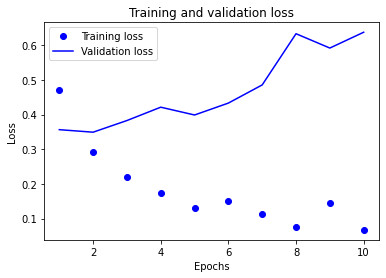

In [200]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

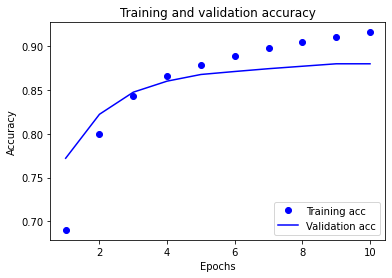

In [50]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the [EarlyStopping callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?version=nightly).

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [54]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 6ms/step - loss: 0.3099 - accuracy: 0.8735
0.8734800219535828


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [55]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6489748 ],
       [0.47473225],
       [0.3922096 ]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multiclass classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multiclass classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

We have prepared a [dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) for you to use containing the body of several thousand programming questions (for example, "How can sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: to increase the difficulty of the classification problem, we have replaced any occurences of the words Python, CSharp, JavaScript, or Java in the programming questions with the word *blank* (as many questions contain the language they're about). 

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) we have prepreared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications. 

1. Modify the last layer of your model to read `Dense(4)`, as there are now four output classes.

1. When you compile your model, change the loss to [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy?version=nightly). This is the correct loss function to use for a multiclass classification problem, when the labels for each class are integers (in our case, they can be 0, *1*, *2*, or *3*).

1. Once these changes are complete, you will be able to train a multiclass classifier. 

If you get stuck, you can find a solution [here](https://github.com/tensorflow/examples/blob/master/community/en/text_classification_solution.ipynb).


## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, we recommend reading [this guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
